## Dynamic time warping

In [76]:
import json
from IPython.display import display, Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

### Load data

In [77]:
def load_data(path: str):
    with open(path) as file:
        json_data = json.load(file)
    df = pd.DataFrame(json_data)

    if "_id" in df.columns:
        df = df.drop(columns="_id")
    if "file" in df.columns:
        df = df.drop(columns="file")
    if "unobfuscated_file" in df.columns:
      df = df.drop(columns="unobfuscated_file")

    return df

unobfuscated_data = load_data("./data/unoptimized/unobfuscated.json")
tigress_data = load_data("./data/unoptimized/tigress.json")
llvm_data = load_data("./data/unoptimized/llvm.json")
wasm_mutate_data = load_data("./data/unoptimized/wasm-mutate.json")

### Pre-process data

In [78]:
transformation_label_map = {
    "flatten": "Flattening",
    "randomfuns": "Random Functions",
    "encodearithmetic": "Encode Arithmetic",
    "encodeliterals": "Encode Literals",
    "split": "Function Splitting",
    "virtualize": "Virtualization",
    "antitaintanalysis": "Anti Taint Analysis",
    "antialiasanalysis": "Anti Alias Analysis"
}

# Create a new column 'transformation_label' based on the 'transformation' column values
tigress_data['transformation_label'] = tigress_data['transformation'].map(transformation_label_map)

# Create a new column 'transformation_label' based on the 'transformation' column values
transformation_label_map = {
    "cffobf": "Control Flow Flattening",
    "bcfobf": "Bogus Control Flow",
    "constenc": "Constants Encryption",
    "strcry": "String Encryption",
    "splitobf": "Basic Block Splitting",
    "indibran": "Indirect Branches",
    "subobf": "Substitute Instruction",
    "funcwra": "Function Wrapper"
}
llvm_data['transformation_label'] = llvm_data['transformation'].map(transformation_label_map)

# Create a new column 'transformation_label' based on the 'mutator' column values
wasm_mutate_data['transformation'] = wasm_mutate_data['mutator']
transformation_label_map = {
    "AddCustomSectionMutator": "Add Custom Section",
    "PeepholeMutator": "Peephole",
    "CodemotionMutator": "Code Motion",
    "AddTypeMutator": "Add Type",
    "AddFunctionMutator": "Add Function",
    "RemoveSection": "Remove Section",
    "RemoveItemMutator": "Remove Item",
    "ReorderCustomSectionMutator": "Reorder Custom Section", 
    "CustomSectionMutator": "Custom Section"
}
wasm_mutate_data['transformation_label'] = wasm_mutate_data['transformation'].map(transformation_label_map)

### Configure Seaborn

In [79]:
sns.set_theme(
    style="whitegrid",
    context="paper",
    font_scale=1.2,
    rc = {
      "figure.figsize": (10, 6),
      "errorbar.capsize": 0.05,
      "xtick.color": "#646464",
      "ytick.color": "#646464",
      "legend.loc": "best",
      "font.family": "Ubuntu",
    }
)

palette = "tab20"
edgecolor = "#646464"
errwidth = 1.8
capsize = 0.05

blues = sns.color_palette("Blues", n_colors= 1)
greens = sns.color_palette("Greens", n_colors=1)
reds = sns.color_palette("Reds", n_colors=1)

bgr_palette = blues + greens + reds

#### Distance plot by obfuscation level

/tmp/ipykernel_17028/1693407175.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wasm_mutate_data['method'] = 'wasm-mutate'


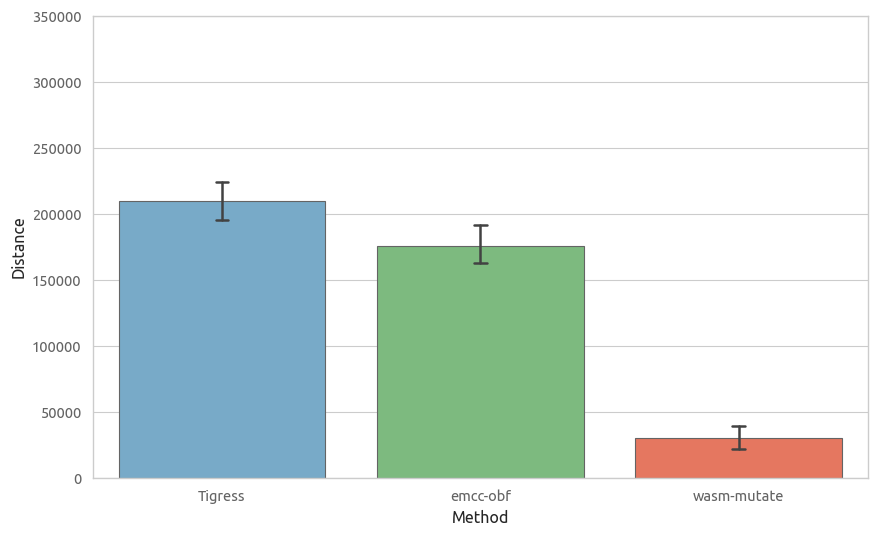

In [80]:
def plot_distance_by_level(df, xlabel, palette=palette,  path=None):    
    sns.barplot(data=df, 
                x='method', 
                y='distance', 
                dodge=False,
                palette=palette, 
                errwidth=errwidth, 
                capsize=capsize, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('Distance')
    plt.xlabel('Method')

    plt.ylim(0, 350000)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

# filter wasm-mutate data
filtered_wasm_mutate_data = wasm_mutate_data[wasm_mutate_data['iteration'] == -1]


# Add a 'method' column to each dataframe
tigress_data['method'] = 'Tigress'
llvm_data['method'] = 'emcc-obf'
filtered_wasm_mutate_data['method'] = 'wasm-mutate'

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
df = pd.concat([tigress_data, llvm_data, filtered_wasm_mutate_data], ignore_index=True)
plot_distance_by_level(df, xlabel='Method', palette=bgr_palette)

**Notes:**

- Tigress is most effective overall 
- Following closely behind Tigress is emcc-obf
- wasm-mutate is miles behind when only applying one mutation

#### Distance plot by transformation

/tmp/ipykernel_17028/1188304510.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wasm_mutate_data['method'] = 'wasm-mutate'


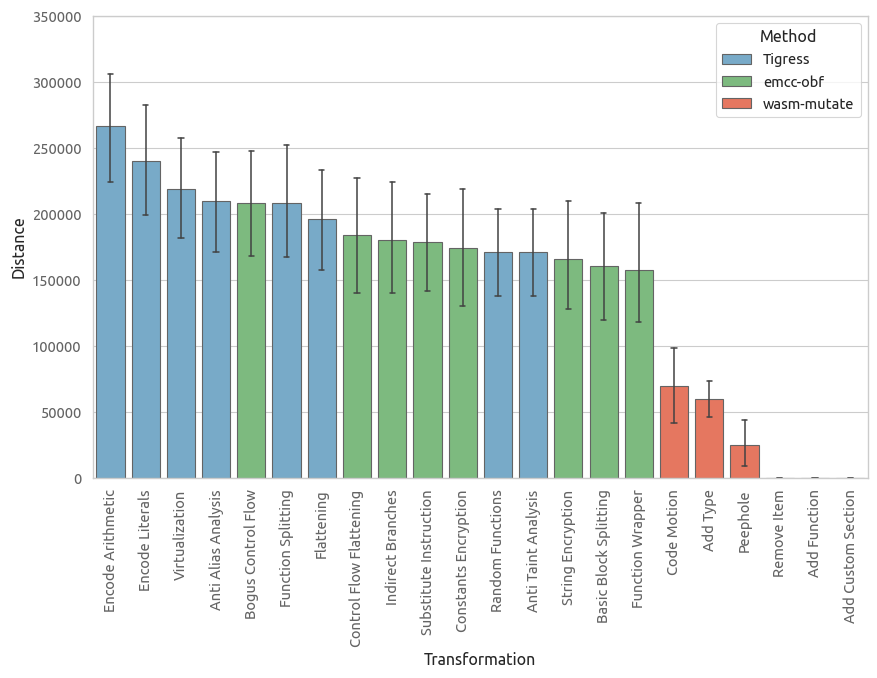

In [81]:
def plot_distance_by_transformation(df, xlabel, palette=None, path=None):
    
    # Compute the average distance for each transformation_label
    avg_distance = df.groupby('transformation_label')['distance'].mean().reset_index()
    
    # Sort DataFrame by descending values of the average distance
    avg_distance_sorted = avg_distance.sort_values('distance', ascending=False)

    # Use the sorted order to sort the original DataFrame by transformation_label
    df['transformation_label'] = pd.Categorical(df['transformation_label'],
                                                categories=avg_distance_sorted['transformation_label'],
                                                ordered=True)
    
    sorted_df = df.sort_values('transformation_label')

    sns.barplot(data=sorted_df, 
                x='transformation_label', 
                y='distance', 
                hue='method',
                dodge=False,
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('Distance')
    plt.xlabel(xlabel)

    plt.xticks(rotation=90)

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Method', loc='upper right')

    plt.ylim(0, 350000)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

# filter wasm-mutate data
filtered_wasm_mutate_data = wasm_mutate_data[wasm_mutate_data['iteration'] == -1]

# Add a 'method' column to each dataframe
tigress_data['method'] = 'Tigress'
llvm_data['method'] = 'emcc-obf'
filtered_wasm_mutate_data['method'] = 'wasm-mutate'

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
df = pd.concat([tigress_data, llvm_data, filtered_wasm_mutate_data], ignore_index=True)
plot_distance_by_transformation(df, xlabel='Transformation', palette=bgr_palette, path='./plots/distance/dist-transformations.png')

**Notes:**

- Encode Arithmetic is the most effective transformation overall.
- Generally Tigress transformations are more effective, but there are exceptions. For instance, control flow flattening is more effective at the LLVM-level (emcc-obf) than at the source code level (Tigress). This may not be attributed entirely to *which* level we are obfuscation at, but rather how *good* the individual obfuscators are. 
- At source-code level, Encode Arithmetic is the most effective transformation. 
- At LLVM-level, control flow flattening is the most effective transformation. 
- At binary level, code motion is the most effective transformation. In general, adding custom sections, functions or removing items have little effect on the resulting WebAssembly binary.

#### wasm-mutate distance by iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


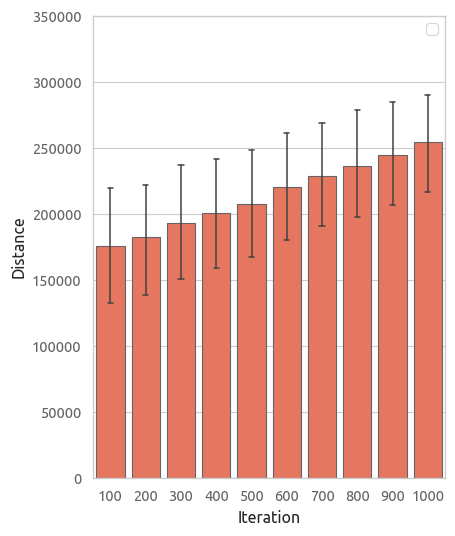

In [82]:
def plot_wasm_mutate_distance(df, palette=palette, path=None):
    plt.figure(figsize=(4.55,6))
    sns.barplot(data=df, 
                x='iteration', 
                y='distance', 
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('Distance')
    plt.xlabel('Iteration')

    # Capitalize the first letter of the entries in the legend
    plt.legend(loc='upper right')

    plt.ylim(0, 350000)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

# Filter wasm-mutate data
df = wasm_mutate_data[wasm_mutate_data['iteration'] != -1]
df = df[df['distance'].notnull()]

red = sns.color_palette("Reds", n_colors=1)
plot_wasm_mutate_distance(df, palette=red, path='./plots/distance/mutate-barplot.png')

**Notes:** 

- Applying several iterations of wasm-mutate yields similar results to Tigress and emcc-obf. 
- After 1000 iterations, it is the second-most effective obfuscation technique overall, almost beating tigress.

/tmp/ipykernel_17028/1988141302.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


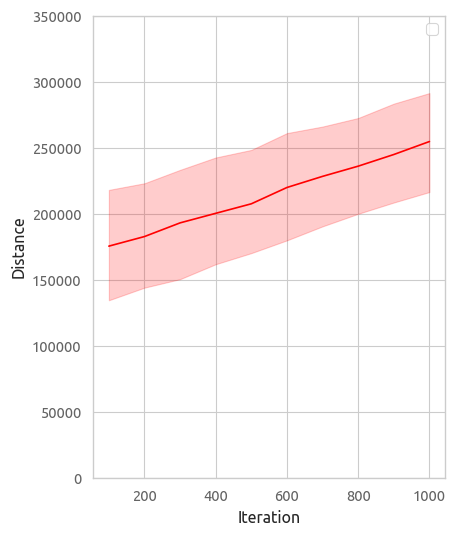

In [83]:
def plot_wasm_mutate_distance_lineplot(df, palette=palette, path=None):
    plt.figure(figsize=(4.55,6))
    sns.lineplot(data=df, 
                x='iteration', 
                y='distance', 
                color='red',
                palette=palette, 
                )
    
    # Axis labels
    plt.ylabel('Distance')
    plt.xlabel('Iteration')

    # Capitalize the first letter of the entries in the legend
    plt.legend(loc='upper right')

    plt.ylim(0, 350000)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

# filter wasm-mutate data
df = wasm_mutate_data[wasm_mutate_data['iteration'] != -1]

red = sns.color_palette("Reds", n_colors=1)
plot_wasm_mutate_distance_lineplot(df, palette=red, path='./plots/distance/mutate-lineplot.png')

#### Distance plot by category

/tmp/ipykernel_17028/3995832239.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wasm_mutate_data['method'] = 'wasm-mutate'


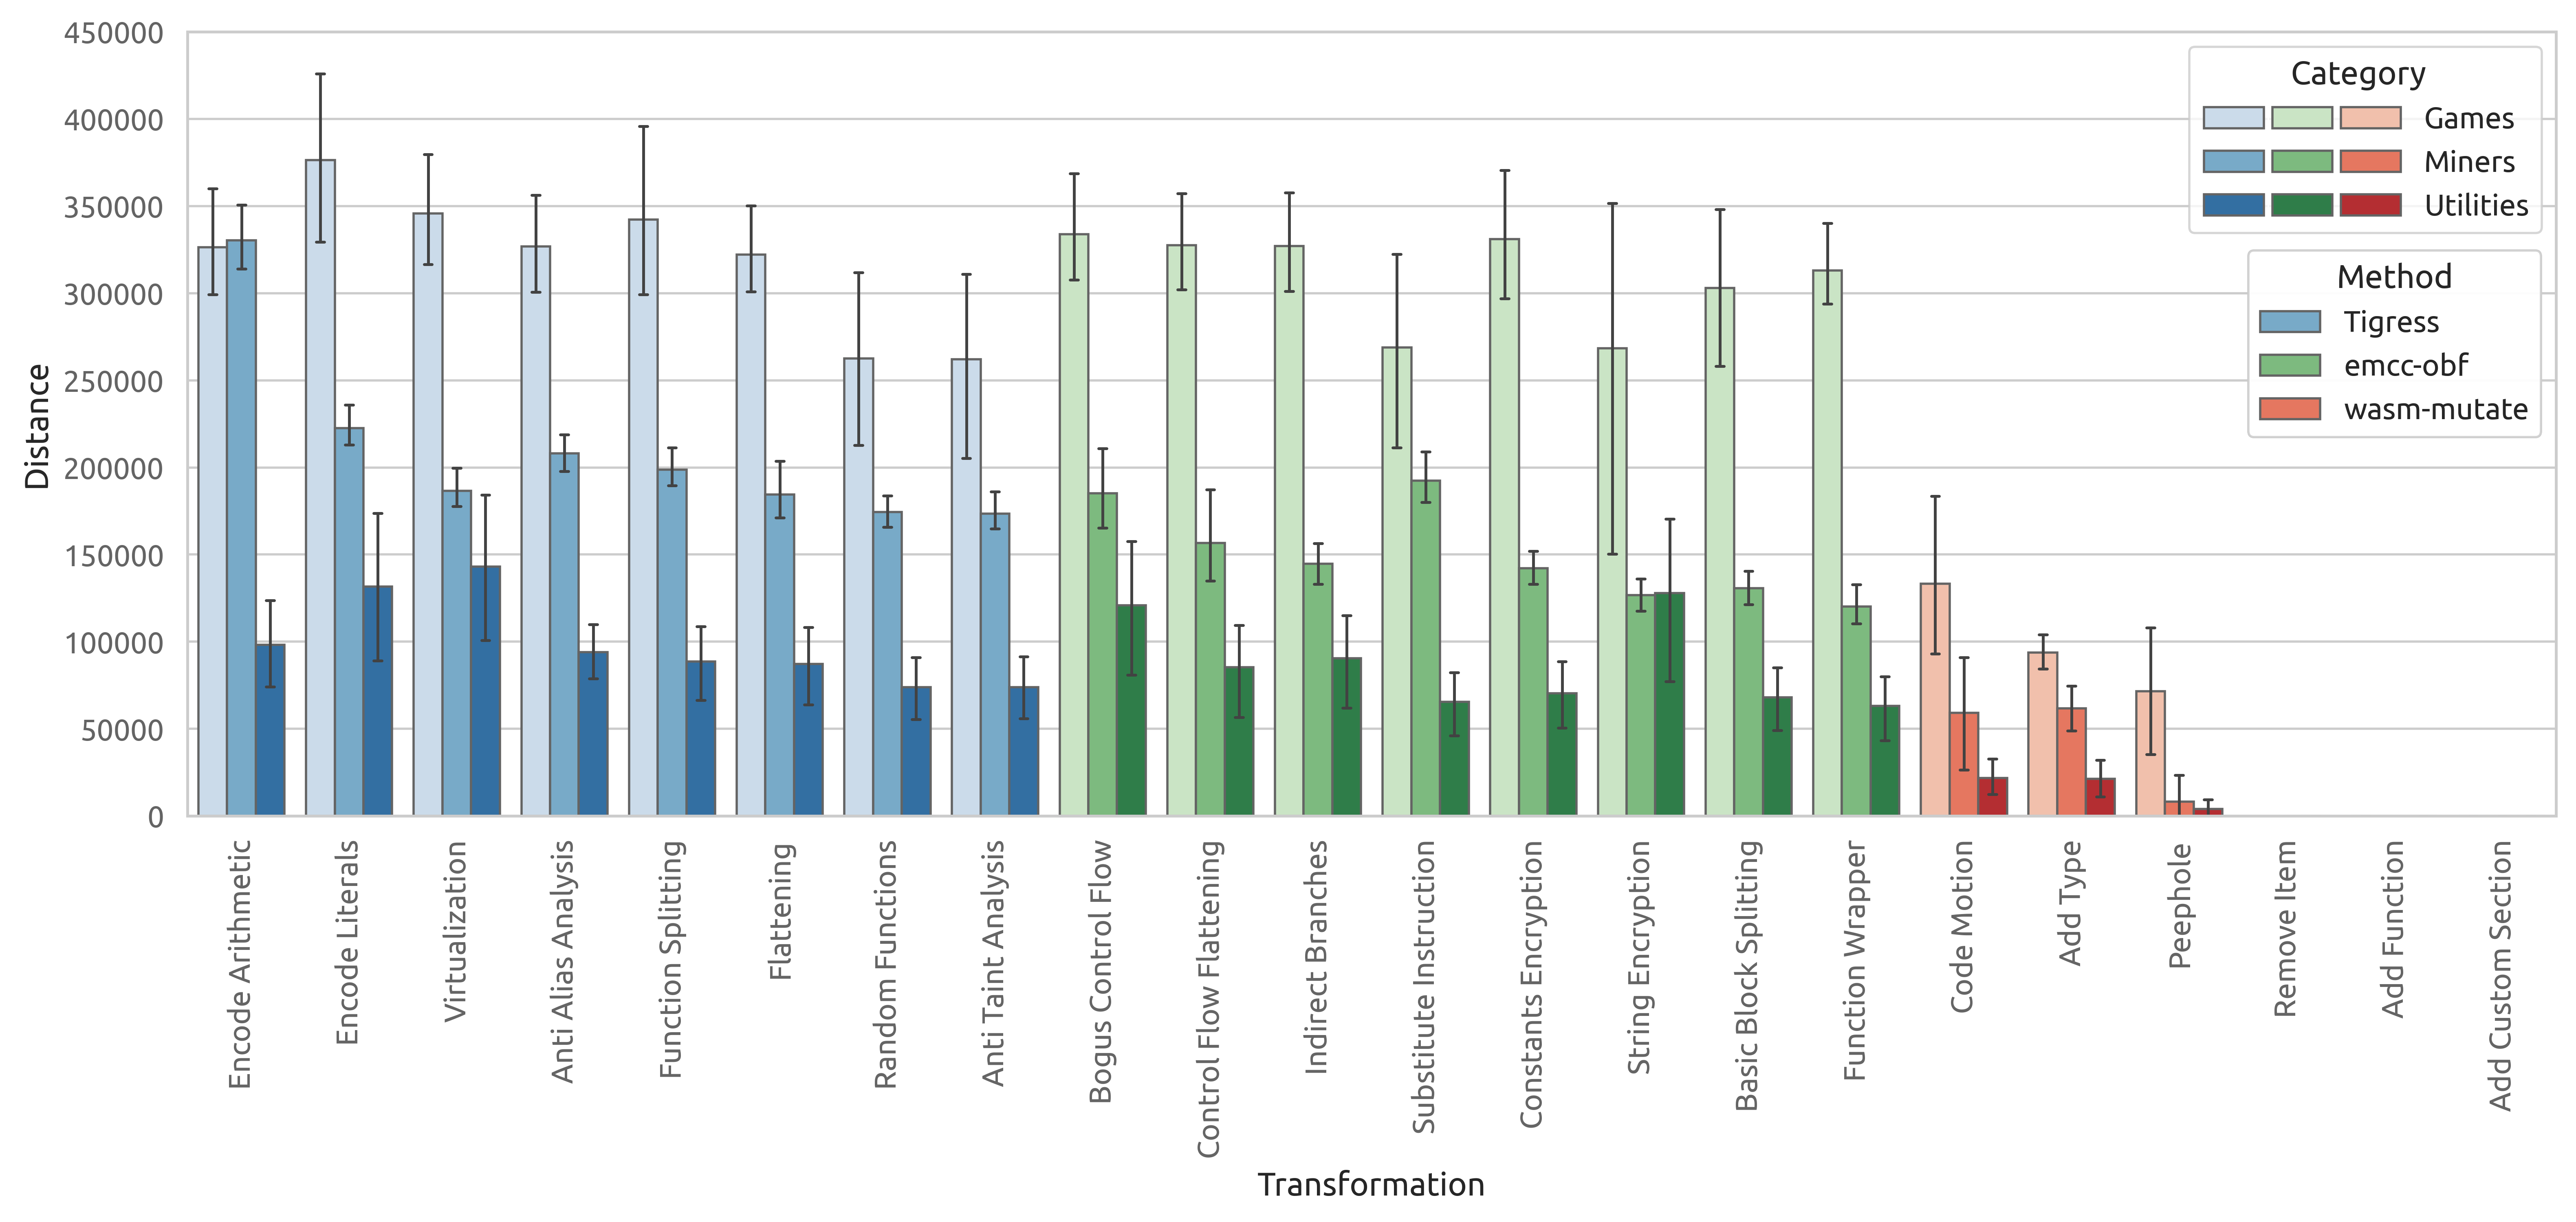

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_distance_by_category(df, xlabel, xlabels=None, path=None, palette=None):
    plt.figure(figsize=(15,5))
    
    # Compute the average distance for each transformation_label within each method
    avg_distance = df.groupby(['method', 'transformation_label'])['distance'].mean().reset_index()
    
    # Sort transformations by the average distance within each method
    avg_distance_sorted = avg_distance.sort_values(['method', 'distance'], ascending=[True, False])

    # Sort the original DataFrame using the sorted transformations
    sorted_transformation_labels = avg_distance_sorted['transformation_label']
    df['transformation_label'] = pd.Categorical(df['transformation_label'], categories=sorted_transformation_labels, ordered=True)
    sorted_df = df.sort_values(['method', 'transformation_label'])

    ax = sns.barplot(data=sorted_df, 
                x='transformation_label', 
                y='distance', 
                hue='category',
                hue_order=['games', 'miners', 'utilities'],
                palette=palette, 
                errwidth=1.0, 
                capsize=0.075, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('Distance')
    plt.xlabel(xlabel)

    plt.ylim(0, 450000)

    # Custom x labels
    if xlabels is not None: 
        plt.xticks(range(len(xlabels)), xlabels, rotation=90)
    else: 
        plt.xticks(rotation=90)

    # Category legend 
    category_legend = ax.legend(title='Category', loc='upper right')
    for text in category_legend.get_texts():
      text.set_text(text.get_text().capitalize())
    ax.add_artist(category_legend)

    method_labels = df['method'].unique()
    method_colors = ["#78AAC8", "#7DBA7F", "#E57760"]
    method_handles = [Patch(facecolor=c, edgecolor=edgecolor, label=label) for label, c in zip(method_labels, method_colors)]
    method_legend = plt.legend(method_handles, method_labels, title='Method', loc='upper right', bbox_to_anchor=(1, 0.74))
    ax.add_artist(method_legend)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=500, bbox_inches="tight")

    # Show the plot 
    plt.show()





# filter wasm-mutate data
filtered_wasm_mutate_data = wasm_mutate_data[wasm_mutate_data['iteration'] == -1]

# Add a 'method' column to each dataframe
tigress_data['method'] = 'Tigress'
llvm_data['method'] = 'emcc-obf'
filtered_wasm_mutate_data['method'] = 'wasm-mutate'

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
combined_data = pd.concat([tigress_data, llvm_data, filtered_wasm_mutate_data], ignore_index=True)

# Display (edited) plot
display(Image(filename='./plots/distance/dist-category.png'))

#plot_distance_by_category(combined_data, xlabel='Transformation', palette="Blues", path='./plots/distance/dist-category-blues.png')
#plot_distance_by_category(combined_data, xlabel='Transformation', palette="Greens", path='./plots/distance/dist-category-greens.png')
#plot_distance_by_category(combined_data, xlabel='Transformation', palette="Reds", path='./plots/distance/dist-category-reds.png')

**Notes:**

- There are big differences between the categories. Most likely attributed to the way the distance is calculated and the file size of the programs we're obfuscating. Games are generally larger than utilities and miners, thus resulting in a longer sequence to align and consequently larger distance. Attempts at normalizing the distance by the file size/sequence length yield uninteresting results. What's important here is the trend however, within each group, and between the groups (not in regards to absolute values)
- For games the most effective transformation is encoding literals. For miners it's encode arithmetic. Lastly, for utilities, encoding literals is also the most efficient. 